In [1]:
import numpy as np
import subprocess
import os
import glob
import yaml
import xarray as xr
import math
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import osprey_io as io
import osprey_means as osm
import osprey_actions as osa

In [2]:
#rdata = osa.forecast_T_local_fit('lf00', 21, 10, 10, True, True)

In [40]:
#
expname='lf01'
leg=201
yearspan=5
yearleap=10
#
endyear = 1990+int(leg)-2
startyear = endyear - yearspan
xf = endyear+yearleap
data = io.readmf_T(expname, startyear, endyear)
x = osm.dateDecimal(data['time'].values.flatten())
ds = data['to'].isel(time=0)
ds_flat = ds.values.flatten()
to_flat = data['to'].values.flatten()
to_reshaped = to_flat.reshape(len(x),-1)
indices = ~np.isnan(to_reshaped)
indices_flat = ~np.isnan(to_flat)
to_valid = to_flat[indices_flat]
size_valid = to_valid.shape[0]/len(x)
to_wonan = np.zeros((len(x), int(size_valid)))
to_wonan = to_reshaped[:, indices[0]]

In [41]:
to_pred = []
model = LinearRegression()
for i in range(to_wonan.shape[1]):
    x_row = np.array(x).reshape(len(x),-1)
    y_row = to_wonan[:, i].reshape(len(x),-1)
    model.fit(x_row, y_row)
    mp = model.coef_[0][0]
    qp = model.intercept_[0]
    yf = model.predict([[xf]])
    to_pred.append(yf[0][0])

In [42]:
y_last = []
for i in range(to_wonan.shape[1]):
    y_last.append(to_wonan[-1, i])
k=0
for i in range(len(to_pred)):
    if to_pred[i] < -1.8:
        to_pred[i] = y_last[i]
        k += 1
print(' Fraction of points below -2deg = ',k/len(to_pred))


 Fraction of points below -2deg =  0.05743557108084506


In [76]:
k=0
deltaTave = 0.0
deltaT = []
for i in range(len(to_pred)):
    k += 1
    deltaT.append(to_pred[i]-y_last[i])
    deltaTave += abs(y_last[i]-to_pred[i]) 
deltaTave = deltaTave/k

In [77]:
deltaTave

1.4715567698162255

In [101]:
deltaT[500]

-3.9163474331793395

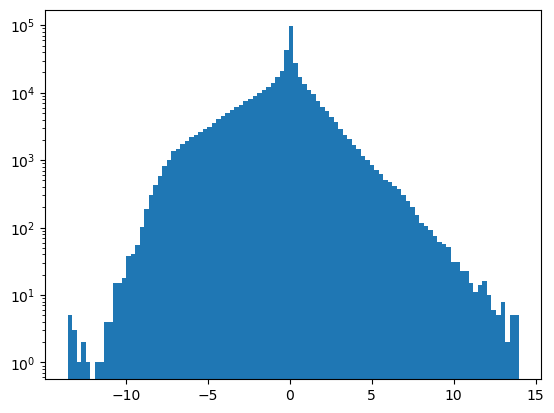

In [78]:
plt.hist(deltaT, bins=100)
plt.yscale('log')
plt.show()

In [46]:
theta = []
j = 0
for i in range(len(ds_flat)):
    if indices[0][i]:
        theta.append(to_pred[j])
        j += 1
    else:
        theta.append(np.nan)
te = np.array(theta).reshape((len(ds['z']),len(ds['y']),len(ds['x'])))

In [47]:
rdata = io.read_restart(expname, leg)
varlist = ['tn', 'tb']
for var in varlist:
    rdata[var] = xr.where(rdata[var]!=0.0, te, 0.0)

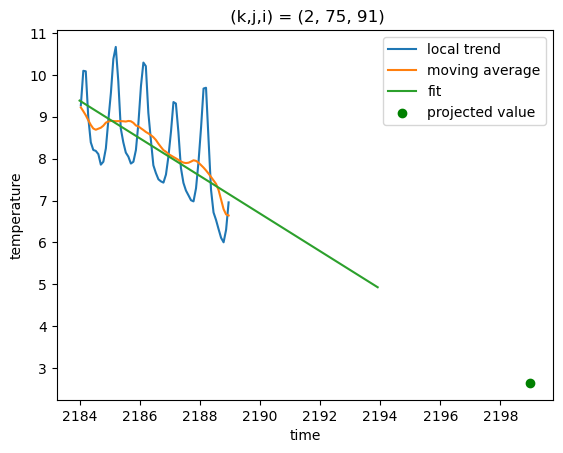

In [193]:
check_fit=True
if check_fit:
    i=random.randint(0, to_wonan.shape[1]-1)
    kji = osm.flatten_to_triad(i, 31, 148, 180)
    model = LinearRegression()
    x_row = np.array(x).reshape(len(x),-1)
    y_row = to_wonan[:,i].reshape(len(x),-1)
    model.fit(x_row, y_row)
    mp = model.coef_[0][0]
    qp = model.intercept_[0]
    yf = model.predict([[xf]])
    if yf < -1.8:
        yf = y_row[-1]
    ym = osm.movave(y_row.flatten(),12).reshape(len(x),-1)
    yp = []; xp = []
    for i in range(len(x)*2):
        xp.append(startyear+i/12.)
        yp.append(mp*(startyear+i/12.)+qp)
    plt.plot(x_row,y_row)
    plt.plot(x,ym)
    plt.plot(xp,yp)
    plt.scatter(xf,yf, color='green')
    plt.ylabel('temperature')
    plt.xlabel('time')
    plt.title('')
    plt.title(' (k,j,i) = {}'.format(kji))
    plt.gca().legend(('local trend','moving average','fit','projected value'))

In [50]:
check_map=True
if check_map:
    rdata0 = io.read_restart(expname, leg)
    dd = xr.where(rdata0['tn']!=0, rdata['tn'].values-rdata0['tn'].values, 0.0)
    #fig = plt.figure(figsize=(1,1), dpi=300)
    #ax = fig.add_subplot(111)
    zlev=0
    dd.isel(time_counter=0,nav_lev=zlev).plot()
    plt.title(' z = {}'.format(zlev))
    #fig.savefig('check_map.png', bbox_inches='tight')

ValueError: Dimensions {'time_counter', 'nav_lev'} do not exist. Expected one or more of ('time', 'z', 'y', 'x')

In [24]:
df = osm.elements(expname='lfr0')  
xdata = io.read_T(expname='lfr0', year=xf)
mdata = xdata['to'].mean('time')
ndata = xr.where(mdata!=0.0, te, 0.0)
delta2 = xr.where(mdata!=0.0, pow(ndata.values-mdata.values,2), 0.0)
err = delta2.weighted(df['vol']).mean(dim=['z', 'y', 'x']).values
err[0]

2.0916516562718153

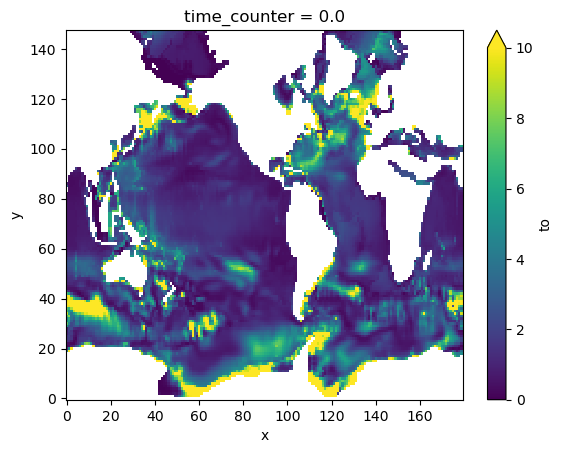

In [25]:
delta2.weighted(df['dz']).mean(dim='z').plot(vmin=0,vmax=10)

In [11]:
rdata

<xarray.Dataset>
Dimensions:       (y: 148, x: 180, z: 31, time: 1)
Coordinates:
  * nav_lev       (z) float32 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
  * time_counter  (time) float32 6.428e+05
Dimensions without coordinates: y, x, z, time
Data variables: (12/41)
    lon           (y, x) float32 dask.array<chunksize=(135, 180), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(135, 180), meta=np.ndarray>
    kt            float64 ...
    ndastp        float64 ...
    adatrj        float64 ...
    ntime         float64 ...
    ...            ...
    sshn          (time, y, x) float64 dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
    un            (time, z, y, x) float64 dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    vn            (time, z, y, x) float64 dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    tn            (time, z, y, x) float64 dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    sn            (time, z, y, x) float64 dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    rhop          (time, z, y, x) float64 dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
Attributes:
    file_name:  /ec/res4/scratch/itas/martini/lf01/111/lf01_00642832_restart.nc
    TimeStamp:  22/04/2024 08:01:33 -0000

In [44]:
new_x = np.linspace(rdata.x.values[0], rdata.x.values[-1], int(rdata.sizes["x"]/2))
new_y = np.linspace(rdata.y.values[0], rdata.y.values[-1], int(rdata.sizes["y"]/2))

In [45]:
# remapping
new_tn = rdata['tn'].interp(x=new_x, y=new_y)

In [46]:
new_tn

<xarray.DataArray 'tn' (time: 1, z: 31, y: 74, x: 90)>
dask.array<transpose, shape=(1, 31, 74, 90), dtype=float64, chunksize=(1, 1, 74, 90), chunktype=numpy.ndarray>
Coordinates:
  * nav_lev       (z) float32 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
  * time_counter  (time) float32 6.428e+05
  * x             (x) float64 0.0 2.011 4.022 6.034 ... 173.0 175.0 177.0 179.0
  * y             (y) float64 0.0 2.014 4.027 6.041 ... 141.0 143.0 145.0 147.0
Dimensions without coordinates: time, z

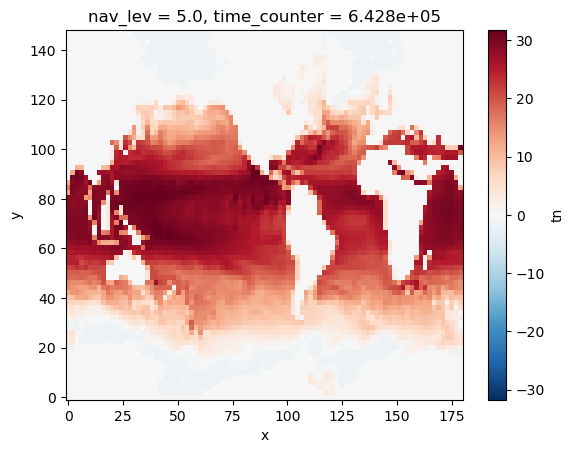

In [47]:
new_tn.isel(time=0,z=0).plot()